# 1D Plug Flow Reactor Model with gas-phase chemistry
In this model, we will illustrate the derivation of the governing differential equations and algebraic constraints, calculation of the initial conditions of the variables and their spatial derivatives and use the IDA solver to solve this system of differential algebraic equations (DAE).

Requires the [scikits.odes.dae](http://scikits-odes.readthedocs.io/en/latest/guide.html#object-oriented-interface-ode-and-dae) solver. The easiest way to install this package is from the `conda-forge` channel using `conda`.

In [1]:
import numpy as np
from scikits.odes import dae
import cantera as ct
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "Times New Roman"

from IPython.display import Image, display
from ipywidgets import widgets, interact
from collections import defaultdict
import subprocess
from subprocess import run
from pathlib import Path

#%matplotlib inline
#%config InlineBackend.figure_formats = ["svg"]
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 3.0.0b1


## Define gas species, bulk species, surface species and the interface

In [2]:
# Import the reaction mechanism 
# mech = 'newer_hcof_c2_CFG.yaml'
mech = 'nist_pfas.yaml'

# Import the models for gas-phase
gas = ct.Solution(mech, 'gas')

## Define reactor conditions : temperature, pressure, fuel, and some important parameters

In [3]:
T0 = 373  # Kelvin
p0 = 1e5
# #gas.TPX = T0, p0, "N2:0.738265428, H2:1.15E-06, O:1.23E-06, OH:8.07E-05, H2O:0.130752753, CO:1.59E-06 O2:0.065447919, c-CH2CH2O:8.68E-06, CO2:0.06544046, CF4:1E-04"
# #gas.TPX = T0, p0, "N2:0.714828183, H2O:0.190113878, CO2:0.095056939, CHF3:1E-06"
# gas.TPX = T0, p0, "H2O:0.190113878, CO2:0.095056939, N2:0.714828183, CF4:0.000001"
gas.TPX = T0, p0, "CH4:1, O2:2, N2:0.7"
T_wall = 500    # Wall temperature [K]
h_coeff = 0

# Geometry
D = 2e-1  # diameter of the tube [m]
Ac = np.pi * D**2/4  # cross-section of the tube [m^2]
perim = np.pi * D  # perimeter of the tube
N = gas.n_species  # number of gas species
n_var = N + 4

# Get initial parameters
rho0 = gas.density  # initial density of the flow
Yk_0 = gas.Y        # initial mass fractions
Xk_0 = gas.X        # inital mole fractions
mu = gas.viscosity
#u0 = 6.55635        # m/s initial velocity of the flow (Taken from BL input file for Re=2500, Tin = 2400K)
# u0 = 5.17628       # m/s initial velocity of the flow (Taken from BL input file for Re=2500, Tin = 2000K)
u0 = 0.517628       # m/s initial velocity of the flow (Taken from BL input file for Re=250, Tin = 2000K)
# Save indices of important species (For one-pass code)
ind_v = 0
ind_T = 3
ind_p = 2
ind_rho = 1
ind_CH4 = gas.species_index('CH4')
ind_CF4 = gas.species_index('CF4')
ind_HF = gas.species_index('HF')
ind_CHF3 = gas.species_index('CHF3')
ind_O2 = gas.species_index('O2')

## Define a residual function for IDA solver

For the isothermal tube with laminar flow, since the temperature of the flow and tube is constant, the energy conservation equation can be ignored. The governing equations include conservation of mass and species, momentum equation, equation of state, and the algebraic constraints that the net production rate of surface species by heterogeneous reactions are zero and that the sum of site fractions equals 1.

Here we define a residual function, an equation which should always evaluate to the zero vector, as the input of IDA solver, which listed as follows:

\begin{align}
    R[0] &= u\frac{d\rho}{dz} + \rho\frac{du}{dz} \\
    R[1] &= \rho u A_c\frac{dY_k}{dz} - \dot{\omega_k}W_kA_c \\
    R[2] &= 2\rho u \frac{du}{dz} + u^2\frac{d\rho}{dz} + \frac{dP}{dz} + \frac{32u\mu}{D^2}\\
    R[3] &= P\bar{W} - \rho RT \\
    R[4] &= \rho u A_c c_p \frac{dT}{dz} +A_c \sum_{K_g}\dot{\omega}_k W_k h_k - hP_w(T_{wall} - T)
\end{align}   

In [4]:
def residual(z, vec, vecp, result):
    """ we create the residual equations for the problem
        vec = [u, rho, p, T, Yk]
        vecp = [dudz, drhodz, dpdz, dTdz, dYkdz]
    """
    # temporary variables
    u = vec[0]  # velocity
    rho = vec[1]  # density
    p = vec[2]  # pressure
    T = vec[3]   # Temperature
    Y = vec[4:4+N]  # vector of mass fractions of all gas species
        
    dudz = vecp[0]  # velocity spatial derivative
    drhodz = vecp[1]  # density spatial derivative
    dpdz = vecp[2]  # pressure spatial derivative
    dTdz = vecp[3]  # temperature spatial derivative
    dYdz = vecp[4:4+N]  # mass fraction spatial derivative
    
    # Use unnormalized mass fractions to avoid over-constraining the system
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T,p
    
    # Save mole fractions
    x_current = gas.X

    # partial enthalpies of gas species
    hk_g = gas.partial_molar_enthalpies 
    
    # temporary variables (based on the given state)
    wdot_g = gas.net_production_rates  # homogeneous production rate of gas species
    W_g = gas.molecular_weights  # vector of molecular weight of gas species

    # mass continuity equation
    result[0] = u*drhodz + rho*dudz
    
    # equation of state
    result[1] = gas.density - rho
    
    # conservation of momentum
    result[2] = 2*rho*u*dudz + np.power(u,2)*drhodz + dpdz + 32*u*mu/D**2 
    
    # energy equation
    result[3] = (rho*u*Ac*gas.cp*dTdz + Ac*np.sum(wdot_g*W_g*hk_g)) - perim*h_coeff*(T_wall - T)

    # conservation of species
    for k in range(N):
        result[4+k] = (rho*u*Ac*dYdz[k] - wdot_g[k]*W_g[k]*Ac)

## Determine the initial values of the spatial derivatives of the unknowns which need to be used as the initial conditions for the IDA solver

In [5]:
# Initialize yPrime to 0 and call residual to get initial derivatives  
y0 = np.hstack((u0, rho0, p0, T0, Yk_0))
yprime0 = np.hstack(np.zeros(n_var))
result = np.hstack(np.zeros(n_var))
residual(0, y0, yprime0, result)
for n in range(n_var):
    yprime0[n] = -result[n]

## Run the IDA solver to calculate the unknowns varying in the flow direction

In [6]:
solver = dae(
    'ida',
    residual, 
    first_step_size=1e-16,
    atol=1e-12,  # absolute tolerance for solution
    rtol=1e-8,  # relative tolerance for solution
    # If the given problem is of type DAE, some items of the residual vector
    # returned by the 'resfn' have to be treated as algebraic equations, and
    # algebraic variables must be defined. These algebraic variables are
    # denoted by the position (index) in the state vector y. All these
    # indexes have to be specified in the 'algebraic_vars_idx' array.
    max_steps=5000,
    old_api=False  # Forces use of new api (namedtuple)
)

times = np.arange(0,12,0.01)
solution = solver.solve(times, y0, yprime0)
#print(solution)

In [7]:
# # Flux path analysis
# from pathlib import Path
# @interact(
#     plot_step=widgets.IntSlider(value=100, min=0, max=len(times), step=10),
#     threshold=widgets.FloatSlider(value=0.0, min=0, max=0.001, step=0.0001),
#     details=widgets.ToggleButton(),
#     species=widgets.Dropdown(
#         options=gas.element_names,
#         value="C",
#         description="Element",
#         disabled=False,
#     ),
# )
# def plot_reaction_path_diagrams(plot_step, threshold, details, species):
#     P = solution.values.y[plot_step,2]
#     T = solution.values.y[plot_step,3]
#     Y = solution.values.y[plot_step,4:4+N]
#     time = times[plot_step]
#     gas.TPY = T, P, Y
#     print("Temperature = {:.2g} K".format(T))
#     print("Length = {:.2g} m".format(time))

#     diagram = ct.ReactionPathDiagram(gas, species)
#     diagram.threshold = threshold

#     diagram.show_details = details
#     dot_file = "reaction_paths.dot"
#     png_file = "reaction_paths.png"
#     diagram.write_dot(dot_file)
#     subprocess.run(f"dot {dot_file} -Tpng -o{png_file} -Gdpi=100".split())
#     img = Image(filename=png_file)
#     display(img)
#     img_path = Path.cwd().joinpath(png_file)

In [8]:
# def save_reaction_path_diagrams(threshold, gas, times, solution):
    
#     element = 'F'
#     N = len(times)
#     nsp = gas.n_species

#     for plot_step in range(N):
#         P = solution.values.y[plot_step,2]
#         T = solution.values.y[plot_step,3]
#         Y = solution.values.y[plot_step,4:4+nsp]
#         time = times[plot_step]
#         gas.TPY = T, P, Y
#         #print("Temperature = {:.2g} K".format(T))
#         #print("Length = {:.2g} m".format(time))

#         diagram = ct.ReactionPathDiagram(gas, element)
#         diagram.threshold = threshold

#         dot_file = 'reaction_paths.dot'
#         img_file = 'reaction_paths'+str(T)+'.png'
#         img_path = Path.cwd().joinpath(img_file)
               
#         diagram.font='Times New Roman'
#         diagram.show_details = False            
#         #diagram.dot_options='bgcolor="#FBFBEF";dpi=300;node[fontsize=20,shape="box3d",style="filled"];'
#         diagram.dot_options='dpi=300;node[fontsize=20];'
#         #edge[arrowhead="onormal",samehead="true"]
#         #diagram.title = 'Reaction path diagram following {0}'.format(element)
#         #diagram.normal_color = "red"
#         diagram.arrow_width = 1
#         diagram.write_dot(dot_file)
#         #print(diagram.get_data())
#         #img = Image(filename=img_file)
#         #display(img)

#         #print("Wrote graphviz input file to '{0}'.".format(Path.cwd().joinpath(dot_file)))

#         run('dot {0} -Tpng -o{1} -Gdpi=300 -Gnodesep=0.5'.format(dot_file, img_file).split())
#         #print("Wrote graphviz output file to '{0}'.".format(img_path))
  
            
# save_reaction_path_diagrams(0.2, gas, times, solution)

## Plot the results

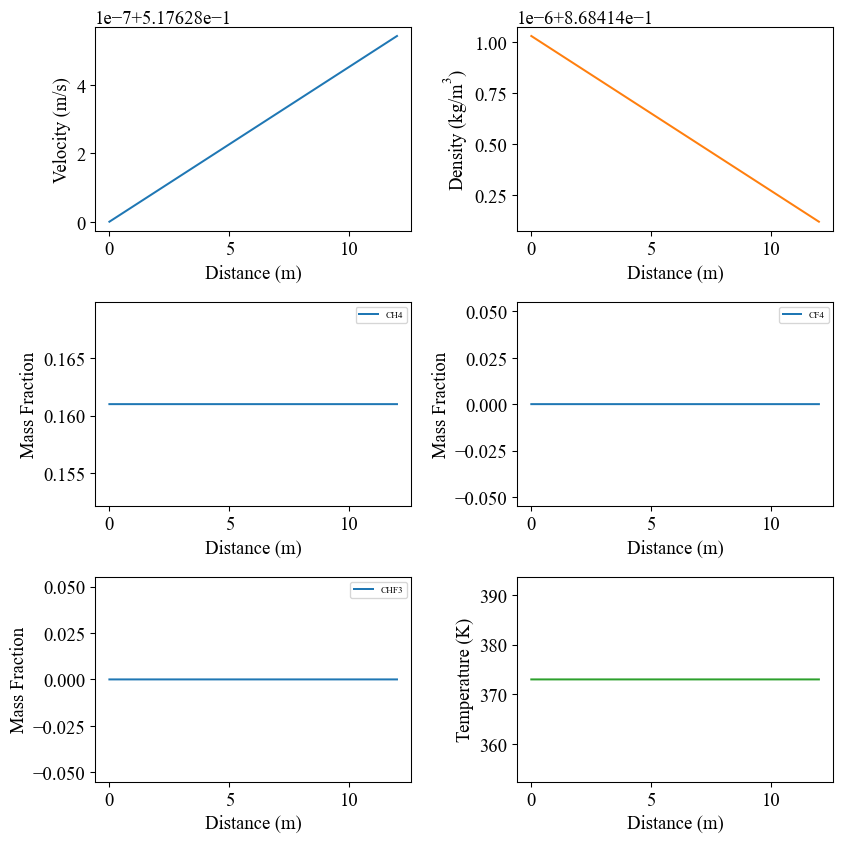

In [19]:
# plot velocity of gas along the flow direction
f, ax = plt.subplots(3,2, figsize=(9,9), dpi=96)
ax[0,0].plot(times, solution.values.y[:,0], color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Velocity (m/s)')

# plot gas density along the flow direction
ax[0,1].plot(times, solution.values.y[:,1], color='C1')
ax[0,1].set_xlabel('Distance (m)')
ax[0,1].set_ylabel('Density ($\mathregular{kg/m^3}$)')
#ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))  # scientific notation


# plot CH4
ax[1,0].plot(times, solution.values.y[:,4+ind_CH4], label=gas.species_names[ind_CH4])
ax[1,0].legend(fontsize=7, loc='upper right')
ax[1,0].set_xlabel('Distance (m)')
ax[1,0].set_ylabel('Mass Fraction')

# plot CF4
ax[1,1].plot(times, solution.values.y[:,4+ind_CF4], label=gas.species_names[ind_CF4])
ax[1,1].legend(fontsize=7, loc='upper right')
ax[1,1].set_xlabel('Distance (m)')
ax[1,1].set_ylabel('Mass Fraction')

# plot CHF3
ax[2,0].plot(times, solution.values.y[:,4+ind_CHF3], label=gas.species_names[ind_CHF3])
ax[2,0].legend(fontsize=7, loc='upper right')
ax[2,0].set_xlabel('Distance (m)')
ax[2,0].set_ylabel('Mass Fraction')

# plot the temperature of the gas along the flow direction
ax[2,1].plot(times, solution.values.y[:,3], color='C2')
ax[2,1].set_xlabel('Distance (m)')
ax[2,1].set_ylabel('Temperature (K)')
f.tight_layout()


In [10]:
# # Get final state
# T = solution.values.y[-1,3]
# p = solution.values.y[-1,2]
# Y = solution.values.y[-1,4:]
# u = solution.values.y[-1,0]
# gas.TPY = T, p, Y
# rho = gas.density
# xf = gas.X

# # Calculate destruction efficiency based on the mole fractions
# DE_CF4 = (Xk_0[ind_CF4] - xf[ind_CF4] )/Xk_0[ind_CF4] * 100
# print("Destruction efficiency for CF4 =", DE_CF4, "%")

# # Calculate destruction efficiency based on the mole fractions
# mdot_in = rho0*u0*Xk_0[ind_CF4]
# mdot_out = rho*u*xf[ind_CF4]
# DE_CF4 = (mdot_in - mdot_out )/mdot_in * 100
# print("Destruction efficiency for CF4 =", DE_CF4, "%")

In [11]:
# # plot velocity of gas along the flow direction
# f, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# p1 = ax1.plot(times, solution.values.y[:,0], label="Velocity", color='C0')
# p2 = ax2.plot(times, solution.values.y[:,4+ind_CHF3], label=gas.species_names[ind_CHF3], color='C1')
# p2 = ax2.plot(times, solution.values.y[:,4+ind_CF4], label=gas.species_names[ind_CF4], color='C1')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Velocity (m/s)')
# ax2.set_ylabel('Y_CF4 ()')
# # Common legend
# p_combined = p1+p2
# labs = [l.get_label() for l in p_combined]
# ax1.legend(p_combined, labs, loc='center right')
# f.tight_layout()
# plt.savefig('pfr1.jpeg', dpi=300)

# f, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# p1 = ax1.plot(times, solution.values.y[:,1], label="Density", color='C0')
# p2 = ax2.plot(times, solution.values.y[:,3], label="Temperature", color='C1')
# ax1.set_ylabel('Density (kg/m3)')
# ax1.set_xlabel('Distance (m)')
# ax2.set_ylabel('Temperature (K)')
# # Common legend
# p_combined = p1+p2
# labs = [l.get_label() for l in p_combined]
# ax1.legend(p_combined, labs, loc='center right')
# f.tight_layout()
# plt.savefig('pfr2.jpeg', dpi=300)

# # plot CF4
# #f, ax = plt.subplots(1,1, dpi=96)
# #ax.plot(times, solution.values.y[:,4+ind_CF4], label=gas.species_names[ind_CF4])
# #ax.legend(fontsize=7, loc='lower right')
# #ax.set_xlabel('Distance (m)')
# #ax.set_ylabel('Mass Fraction')

# f.tight_layout()

In [12]:
# f, ax = plt.subplots(1,1, dpi=96)
# ax.plot(times, solution.values.y[:,4+ind_CF4], label=gas.species_names[ind_CF4])
# #ax.plot(times, solution.values.y[:,4+ind_CHF3], label=gas.species_names[ind_CHF3])
# ax.legend(fontsize=7, loc='lower right')
# ax.set_xlabel('Distance (m)')
# ax.set_ylabel('Mass Fraction')

In [13]:
# ###### Compare with BL code
# import pandas as pd
# i_arr = [0]
# baseFolder = 'C:/brownUniversity/boundary_layer_problem/NIST/Tin/Tin=2000K/Re_2500/'

# # Plot
# plt.rcParams['font.size'] = 14
# f, ax = plt.subplots(2,2, figsize=(12, 8), dpi=96)

# ax[0,0].plot(times, solution.values.y[:,ind_v], color='C1', label='Plug flow model')
# ax[0,0].set_xlabel('Distance (m)')
# ax[0,0].set_ylabel('Velocity (m/s)')
# ax[0,1].plot(times, solution.values.y[:,ind_T], color='C1', label='Plug flow model')
# ax[0,1].set_xlabel('Distance (m)')
# ax[0,1].set_ylabel('Temperature (K)')
# ax[1,0].plot(times, solution.values.y[:,4+ind_CF4], color='C1', label='Plug flow model')
# ax[1,0].set_xlabel('Distance (m)')
# ax[1,0].set_ylabel('X_CF4 ()')
# ax[1,1].plot(times, solution.values.y[:,4+ind_HF], color='C1', label='Plug flow model')
# ax[1,1].set_xlabel('Distance (m)')
# ax[1,1].set_ylabel('X_HF ()')

# # # Indices for variables (Hard coded for now)
# # indBL_vel = 1
# # indBL_pres = 3
# # indBL_T = 4
# # indBL_CO = 27
# # indBL_CO2 = 53
# # indBL_N2 = 7
# # indBL_HF = 71
# # indBL_CHF3 = 77
# # indBL_CF4 = 78
# # indBL_CH4 = 15
# # indBL_H2O = 18

# # For NIST file
# indBL_vel = 1
# indBL_pres = 3
# indBL_T = 4
# indBL_HF = 45
# indBL_CHF3 = 50
# indBL_CF4 = 51

# for i in range(len(i_arr)):
#     filename = baseFolder + 'i_' + str(i_arr[i]) + '.csv'
#     data = pd.read_csv(filename).values
#     points = data[:,0].size
#     z = data[:,0]*D
#     nvar = data[0,:].size

#     ax[0,0].plot(z, data[:, indBL_vel], color='C0', label='Boundary Layer model')
#     ax[0,1].plot(z, data[:, indBL_T], color='C0', label='Boundary Layer model')
#     ax[1,0].plot(z, data[:, indBL_CF4], color='C0', label='Boundary Layer model')
#     ax[1,1].plot(z, data[:, indBL_HF], color='C0', label='Boundary Layer model')
#     ax[0,0].legend()
#     ax[0,1].legend()
#     ax[1,0].legend()
#     ax[1,1].legend()

# f.tight_layout()

In [14]:
# # Compare with BL code
# import pandas as pd
# i_arr = [0]
# baseFolder = 'C:/brownUniversity/boundary_layer_problem/pfr_comparison/'

# # Plot
# plt.rcParams['font.size'] = 20
# #plt.rc('xtick', direction='in') 
# #plt.rc('ytick', direction='in') 
# f, ax = plt.subplots(1,2, figsize=(12, 3), dpi=300)
# #ax[0].set_xlim([-0.1, 5.1])
# #ax[1].set_xlim([-0.1, 5.1])
# ax[0].set_xticks([0,1,2,3,4,5])
# ax[0].set_yticks([1800, 2000, 2200, 2400])
# ax[1].set_xticks([0,1,2,3,4,5])
# plt.rcParams['axes.linewidth'] = 1.5
# ax[0].tick_params(direction='in', length=5, width=1.5, colors='k')
# ax[0].plot(times, solution.values.y[:,ind_T], color='k',label='T_PFR', linewidth = 2)
# #ax[0].set_xlabel('Distance along the reactor [m]')
# #ax[0].set_ylabel('Temperature [K]')
# ax[1].tick_params(direction='in', length=5, width=1.5, colors='k')
# ax[1].plot(times, solution.values.y[:,4+ind_CF4], color='k', label='CF4_PFR', linewidth = 2)
# #ax[1].set_xlabel('Distance along the reactor [m]')
# #ax[1].set_ylabel('Mole fraction []')
# ax[1].plot(times, solution.values.y[:,4+ind_HF], color='k', label='HF_PFR', linewidth = 2)
# #ax[1,1].set_xlabel('Distance (m)')
# #ax[1,1].set_ylabel('X_CHF3 ()')

# # Indices for variables (Hard coded for now)
# indBL_T = 4
# indBL_HF = 71
# indBL_CHF3 = 77
# indBL_CF4 = 78
# for i in range(len(i_arr)):
#     filename = baseFolder + 'i_' + str(i_arr[i]) + '.csv'
#     data = pd.read_csv(filename).values
#     points = data[:,0].size
#     z = data[:,0]*D
#     nvar = data[0,:].size

#     ax[0].plot(z, data[:, indBL_T], color='r', label='T_BL', linewidth = 2)
#     ax[1].plot(z, data[:, indBL_CF4], color='r', label='CF4_BL', linewidth = 2)
#     ax[1].plot(z, data[:, indBL_HF], color='r', label='HF_BL', linewidth = 2)
#     #ax[0].legend()
#     #ax[1].legend()
# #f.tight_layout()
# #plt.savefig('BL_PFR.jpeg', dpi=300)
# plt.savefig('BL_PFR.svg', dpi=1000)


In [15]:
# ###### Compare with BL code
# import pandas as pd
# i_arr = [0]
# baseFolder = 'C:/brownUniversity/boundary_layer_problem/NIST/Tin/Tin=2000K/Re_2500/'

# # Plot
# plt.rcParams['font.size'] = 14
# fig=plt.figure(figsize=(12,3), dpi= 100)
# plt.rcParams["figure.figsize"] = (6,3)
# fig, ax1 = plt.subplots()

# #ax1.plot(times, solution.values.y[:,4+ind_CHF3], color='k', label='Plug flow model')
# ax1.plot(times, solution.values.y[:,4+ind_CF4], color='k', label='Plug flow model')
# ax1.plot(times, solution.values.y[:,4+ind_HF], color='k', label='Plug flow model')
# ax1.set_xlabel('Axial Distance [m]')
# ax1.set_ylabel('Mole fractions []')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(times, solution.values.y[:,ind_T], color='r', label='Plug flow model')
# ax2.set_ylabel('Temperature [K]')
# #ax1.legend()
# #ax2.legend()
# plt.savefig('BL_PFR1.svg', dpi=1000)

In [16]:
# # Plot
# plt.rcParams['font.size'] = 14
# fig=plt.figure(figsize=(12,3), dpi= 100)
# plt.rcParams["figure.figsize"] = (6,3)
# fig, ax1 = plt.subplots()

# # For NIST file
# indBL_T = 4
# indBL_HF = 45
# indBL_CHF3 = 50
# indBL_CF4 = 51

# for i in range(len(i_arr)):
#     filename = baseFolder + 'i_' + str(i_arr[i]) + '.csv'
#     data = pd.read_csv(filename).values
#     points = data[:,0].size
#     z = data[:,0]*D
#     nvar = data[0,:].size

#     #ax1.plot(z, data[:, indBL_CHF3], color='C0', label='Boundary Layer model')
#     ax1.plot(z, data[:, indBL_CF4], color='k', label='Boundary Layer model')
#     ax1.plot(z, data[:, indBL_HF], color='k', label='Boundary Layer model')
    
#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.plot(z, data[:, indBL_T], color='r', label='Boundary Layer model')
    
#     ax1.set_xlabel('Axial Distance [m]')
#     ax1.set_ylabel('Mole fractions []')
#     ax2.set_ylabel('Temperature [K]')
    
# #f.tight_layout()
# plt.savefig('BL_PFR2.svg', dpi=1000)

In [18]:
# ###### Compare with BL code COMBINED PLOTS
# import pandas as pd
# i_arr = [0]
# baseFolder = 'C:/brownUniversity/boundary_layer_problem/NIST/Tin/Tin=2000K/Re_250/'

# # Plot
# plt.rcParams['font.size'] = 14
# fig=plt.figure(figsize=(12,3), dpi= 100)
# plt.rcParams["figure.figsize"] = (6,3)
# fig, ax1 = plt.subplots()
# ax1.tick_params(axis="y",direction="in")

# # For NIST file
# indBL_T = 4
# indBL_HF = 45
# indBL_CHF3 = 50
# indBL_CF4 = 51

# filename = baseFolder + 'i_' + str(i_arr[0]) + '.csv'
# data = pd.read_csv(filename).values
# points = data[:,0].size
# z = data[:,0]*D

# ax1.plot(times, solution.values.y[:,4+ind_CF4], color='k', label='Plug flow model', linestyle = '--')
# #ax1.plot(times, solution.values.y[:,4+ind_HF], color='b', label='Plug flow model', linestyle = '--')
# ax1.plot(z, data[:, indBL_CF4], color='k', label='Boundary Layer model')
# #ax1.plot(z, data[:, indBL_HF], color='b', label='Boundary Layer model')
# ax1.set_xlabel('Axial Distance [m]')
# ax1.set_ylabel('Mass fractions []')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.tick_params(axis="y",direction="in", color='r')
# ax2.plot(times, solution.values.y[:,ind_T], color='r', label='Plug flow model', linestyle = '--')
# ax2.plot(z, data[:, indBL_T], color='r', label='Boundary Layer model')
# ax2.set_ylabel('Temperature [K]', color='r')
# ax2.spines['right'].set_color('r')
# ax2.tick_params(axis='y', colors='r')
# #ax1.legend()
# #ax2.legend()
# plt.savefig('BL_PFR-Re250-1.svg', dpi=1000)